# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
#from eofs.xarray import Eof 

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [4]:
from load_ensembles import *
import quick_map

In [5]:
path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/'

# Load data

In [6]:
ds = xr.open_dataset(path_in+'delta_calculated_PRECT_Annual_mean.nc')['calculated_PRECT']
from load_gridcell_areas import *

In [7]:
pvals=xr.open_dataset(path_in+'pval_calculated_PRECT_Annual_mean.nc')['pval']

In [8]:
ds_ref=xr.open_dataset(path_in+'ref_calculated_PRECT_Annual_mean.nc')['calculated_PRECT']

In [9]:
landweights=landweights.reindex_like(ds_ref, method='nearest',tolerance=0.05)

# Do some calculations

In [10]:
pct_change=(ds)*100/ds_ref
sig_pct_change=pct_change.where(pvals<=0.05)
sig_pct_change=sig_pct_change.where(~np.isnan(sig_pct_change),0)

pct_change_range=(sig_pct_change).max(dim='ensemble_key')-(sig_pct_change).min(dim='ensemble_key')
pct_change_range=pct_change_range.where(~np.isnan(pct_change_range),0).where(landweights>0)

In [11]:
# Global averages
ds_global=(ds*landweights).mean(dim=['lat','lon'])
ref_global=(ds_ref*landweights).mean(dim=['lat','lon'])
ds_delta_global_pct=(ds_global)*100/ref_global

# Global averages
pct_range=(np.abs(pct_change)*landweights).mean(dim=['lat','lon'])

# Figure 2a

In [12]:
mapdata=pct_change_range
sigmask=((pvals<=0.05).sum(dim='ensemble_key')<=5)

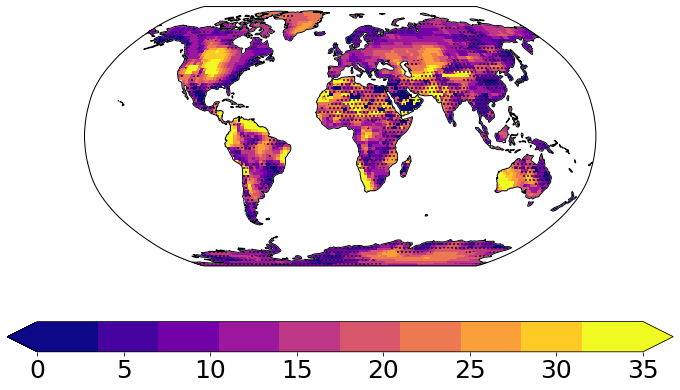

In [13]:
import cartopy
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("plasma",10), vmin=0, vmax=35,#levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-0.025, 0.030, 0.005))

cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=sigmask.lon)
ax.contourf(
            cyclic_lons_mask, sigmask.lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['...'])
        
plt.tight_layout()
ax.add_feature(cartopy.feature.OCEAN, facecolor='white', zorder=1)
ax.coastlines()
plt.savefig('Range_pct_change.png')
plt.savefig('Figures/Range_pct_change.eps')

# Figure 2b

In [214]:
crosswalk['delta_PRECT']=np.nan
for i, key in enumerate(ds.ensemble_key.values):
    crosswalk.loc[crosswalk.Key_short==key,['delta_PRECT']]=pct_range.values[i]

In [1]:
from plotting_settings import *

In [216]:
param_ranges=[]
for i, param in enumerate(params):
    minind=(crosswalk.description==param+', min')
    maxind=(crosswalk.description==param+', max')
    
    minarray=sig_pct_change[:,:,minind].mean(dim='ensemble_key')
    maxarray=sig_pct_change[:,:,maxind].mean(dim='ensemble_key')
    
    param_range=(np.abs(maxarray-minarray)*landweights).mean(dim=['lat','lon'])
    param_ranges.append(param_range)

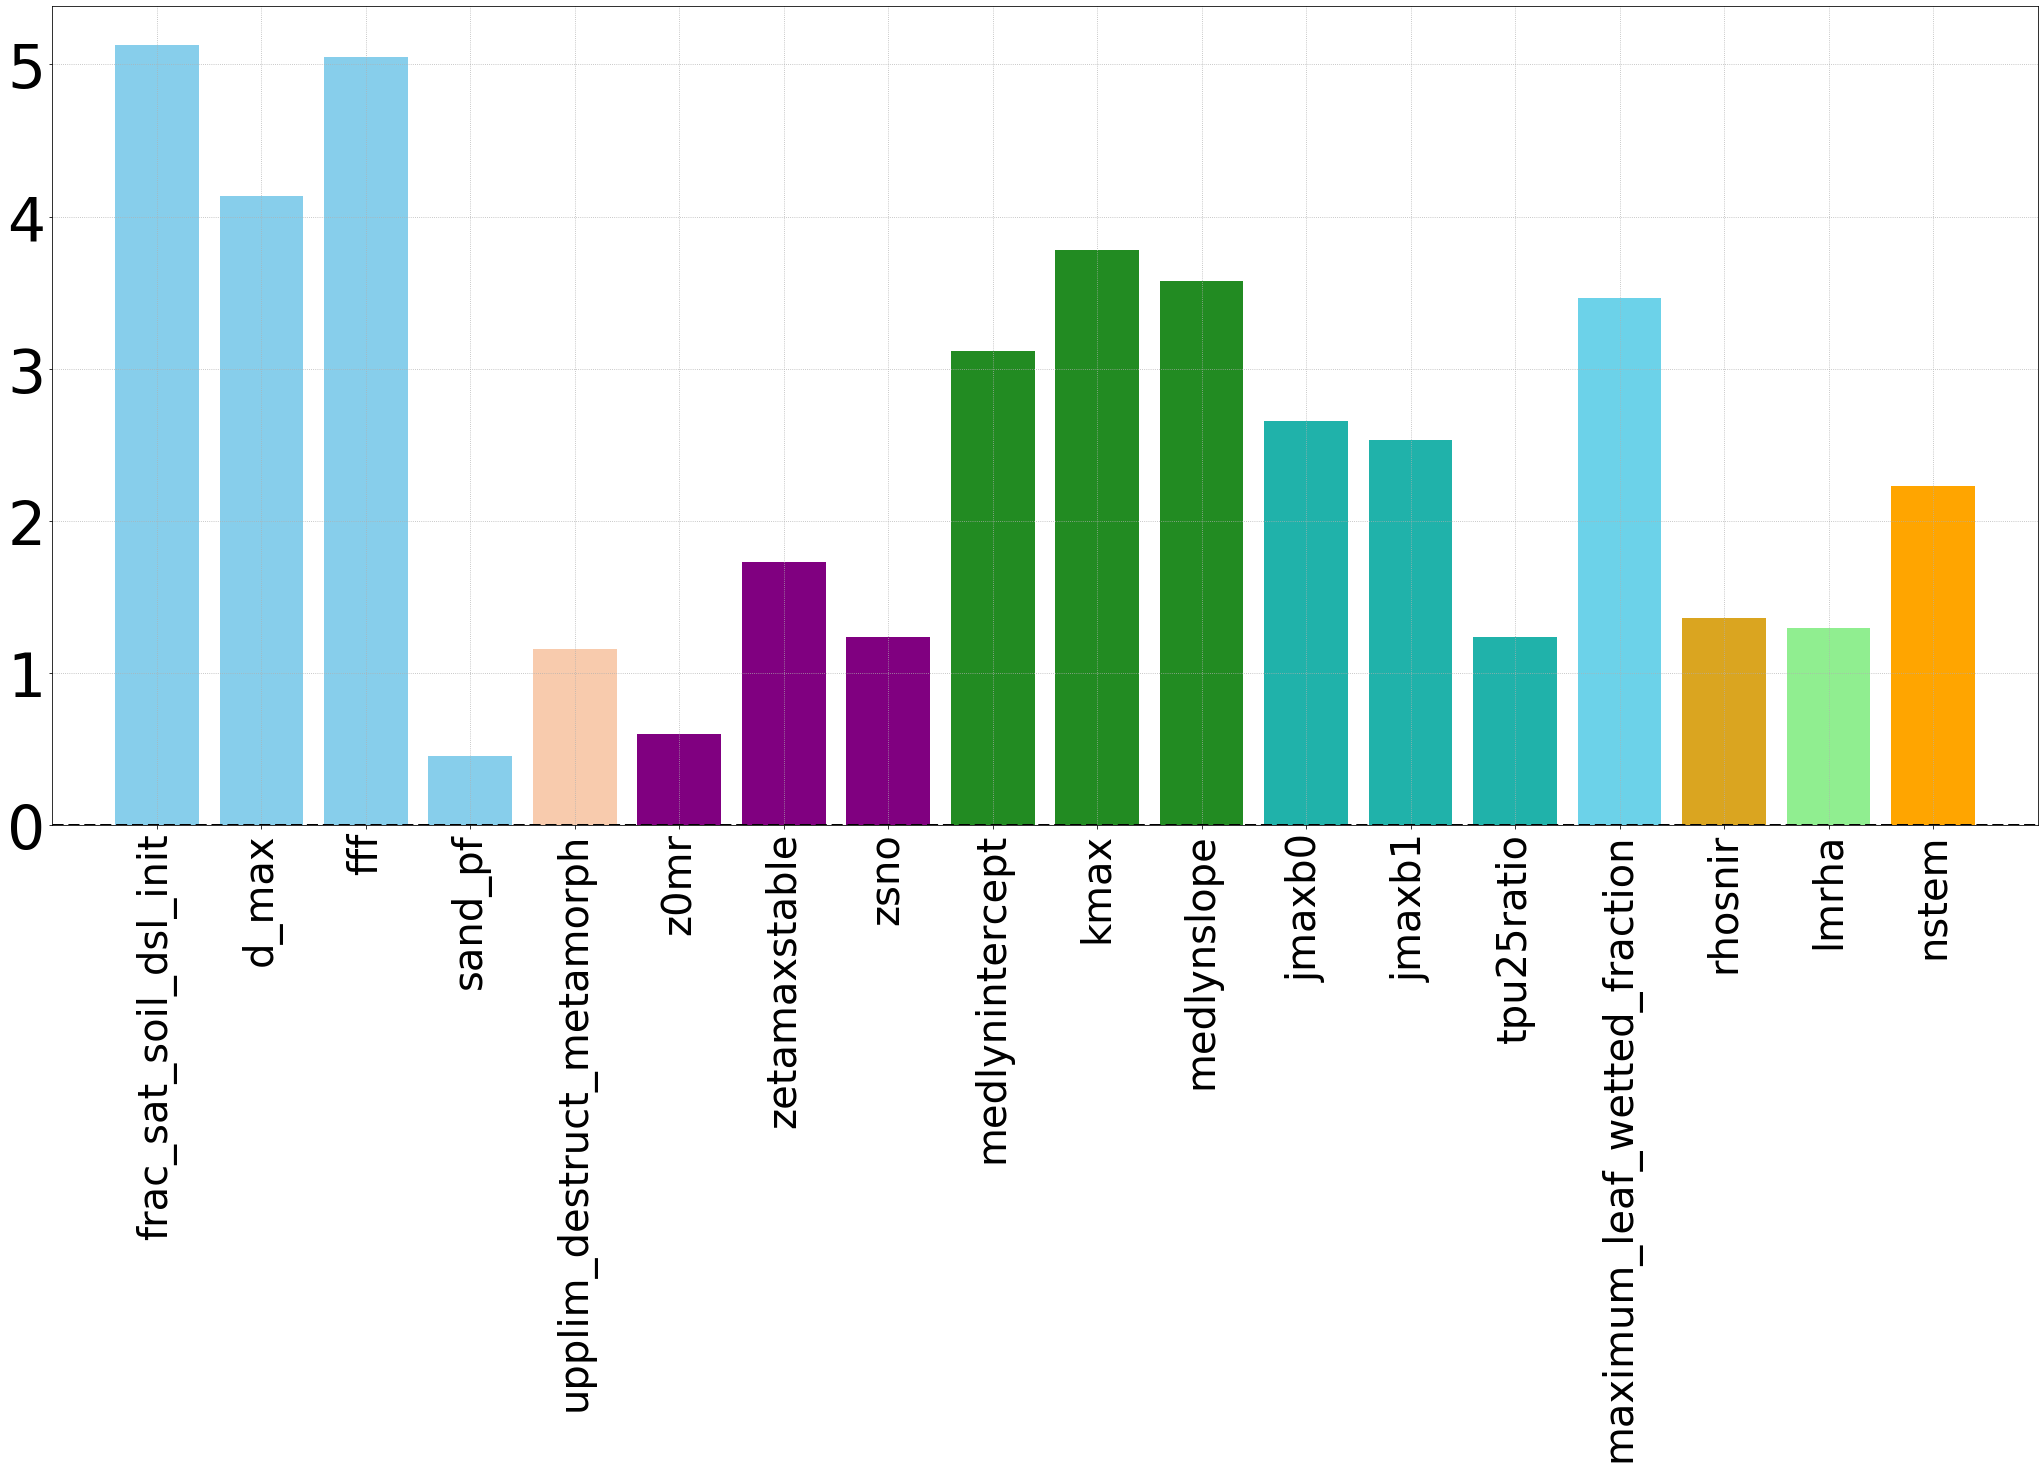

In [229]:
plt.rcParams.update({'font.size': 60})
plt.figure(figsize=(30,22))
lwidth=3
plt.axhline(y=0,linestyle='--',color='k', linewidth=lwidth)

for i, param in enumerate(params):
    
    plt.bar(i,param_ranges[i], color=param_colors[i])

xticks=plt.xticks(np.arange(0, i+1), params, rotation='vertical',fontsize=40)
plt.grid(linestyle=':')
plt.xlim([-1,np.size(params)])
plt.tight_layout()
plt.savefig('Figures/Figure2b.eps')

# Figure 2c?

In [225]:
ds_Ts = xr.open_dataset(path_in+'delta_TSKIN_Annual_mean.nc')['TSKIN']
pvals_Ts=xr.open_dataset(path_in+'pval_TSKIN_Annual_mean.nc')['pval']
sig_ds_Ts=ds_Ts.where(pvals_Ts<=0.05,0)
delta_Ts=(sig_ds_Ts*landweights).mean(dim=['lat','lon'])

In [226]:
param_ranges_Ts=[]
for i, param in enumerate(params):
    minind=(crosswalk.description==param+', min')
    maxind=(crosswalk.description==param+', max')
    
    minarray=ds_Ts[:,:,minind].mean(dim='ensemble_key')
    maxarray=ds_Ts[:,:,maxind].mean(dim='ensemble_key')
    
    param_range_Ts=(np.abs(maxarray-minarray)*landweights).mean(dim=['lat','lon']).values
    param_ranges_Ts.append(param_range_Ts)

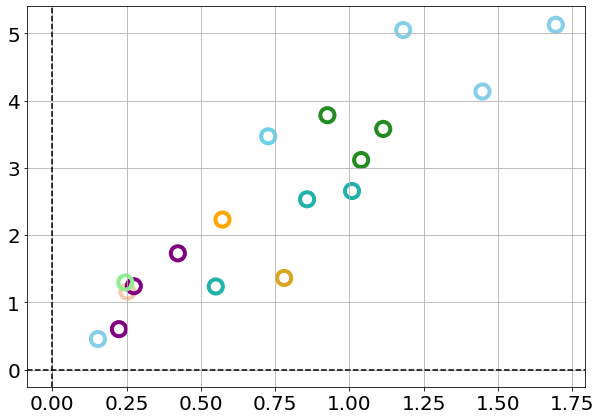

In [228]:
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(10,7))
plt.scatter(param_ranges_Ts, param_ranges, s=200, 
            edgecolors=param_colors,facecolors='none',linewidth=4)
#plt.xlim([-0.1,1.8])
#plt.ylim([-0.5,8.5])
plt.grid()
plt.axhline(y=0,linestyle='--',color='k')
plt.axvline(x=0,linestyle='--',color='k')
plt.savefig('Figures/Figure2c.eps')